
# Cocoa Structural Break Workflow (WLL vs. ML)

This notebook follows the workflow in the **WLL Cocoa Extension proposal** (hypothesis section omitted). It is designed so your supervisor can click **Run All** to reproduce the end-to-end experiment:

1. Load the prepared cocoa + weather dataset
2. Detect a single structural break (Mohr & Selk style search over split points)
3. Fit pre-break and post-break local regressors
4. Choose the WLL mixing weight `gamma` via Modified Forward Validation (MFV, Q=4)
5. Compare against ML baselines (Random Forest, optional XGBoost)
6. Report post-break MSFE and plot the forecasts


In [1]:
# Quick settings – no edits needed
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
import sys
from typing import Tuple

ROOT = Path.cwd()
if not (ROOT / "src").exists():
    ROOT = ROOT.parent
SRC_PATH = ROOT / "src"
if SRC_PATH.exists():
    os.chdir(ROOT)
    sys.path.append(str(SRC_PATH))

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

np.random.seed(42)
DATA_PATH = Path("data/processed/cocoa_ghana_full.csv")


In [2]:
# 1) Load data (tries to build features if the CSV is missing)
if not DATA_PATH.exists():
    from cocoa.data.features import build_features
    raw_dir = Path("data/raw")
    processed_dir = Path("data/processed")
    print("Processed file missing – building from raw inputs...")
    _ = build_features(raw_dir, processed_dir, reading_path='Ghana_data_full.csv', file_name=DATA_PATH.name)
df = pd.read_csv(DATA_PATH, parse_dates=["date"])
# Keep only the columns we need for modeling
feature_cols = [
    "PRCP_anom_mean",
    "TAVG_anom_mean",
    "PRCP_anom_std",
    "TAVG_anom_std",
    "N_stations",
    "log_price_lagt",
]
target_col = "log_return_forecast_target"
print(f"Loaded {len(df):,} observations with features: {feature_cols}\nTarget: {target_col}")
df.head()

Loaded 6,734 observations with features: ['PRCP_anom_mean', 'TAVG_anom_mean', 'PRCP_anom_std', 'TAVG_anom_std', 'N_stations', 'log_price_lagt']
Target: log_return_forecast_target


,date,PRCP_anom_mean,TAVG_anom_mean,PRCP_anom_std,TAVG_anom_std,N_stations,log_price,log_price_lagt,log_return,log_return_forecast_target
0,1994-10-04,0.0000,0.25,0.000000,0.000000,1,7.287752,7.290457,-0.002704,-0.021924
1,1994-10-05,0.0925,0.00,0.137886,2.828427,2,7.265828,7.287752,-0.021924,-0.000175
2,1994-10-06,0.0040,-0.40,0.005657,0.565685,2,7.265653,7.265828,-0.000175,-0.009737
3,1994-10-07,-0.0284,0.46,0.377151,1.306905,5,7.255916,7.265653,-0.009737,-0.001929
4,1994-10-10,-0.4325,-4.00,0.000000,0.000000,1,7.253987,7.255916,-0.001929,0.000149


In [3]:

# 2) Helper: simple Mohr–Selk style break detection

def detect_break_least_squares(series: pd.Series, trim: float = 0.1) -> int:
    '''Return the index (0-based) that minimizes pre/post squared error.'''
    y = series.values
    T = len(y)
    start = int(T * trim)
    end = int(T * (1 - trim))
    best_idx, best_score = start, np.inf
    prefix_sum = np.cumsum(y)
    prefix_sq = np.cumsum(y ** 2)

    for k in range(start, end):
        n1 = k
        n2 = T - k
        if n1 == 0 or n2 == 0:
            continue
        mean1 = prefix_sum[k-1] / n1
        mean2 = (prefix_sum[-1] - prefix_sum[k-1]) / n2
        sse1 = prefix_sq[k-1] - 2 * mean1 * prefix_sum[k-1] + n1 * mean1 ** 2
        sse2 = (prefix_sq[-1] - prefix_sq[k-1]) - 2 * mean2 * (prefix_sum[-1] - prefix_sum[k-1]) + n2 * mean2 ** 2
        total = sse1 + sse2
        if total < best_score:
            best_score = total
            best_idx = k
    return best_idx

break_idx = detect_break_least_squares(df[target_col])
break_date = df.loc[break_idx, "date"].date()
print(f"Estimated break date: {break_date} (index {break_idx})")


Estimated break date: 2022-07-05 (index 6058)


In [4]:

# 3) Prepare train / validation / test splits

df_sorted = df.sort_values("date").reset_index(drop=True)

pre_break = df_sorted.iloc[:break_idx]
post_break = df_sorted.iloc[break_idx:]

# Hold out the last 25% of post-break data for out-of-sample testing
holdout_start = break_idx + int(len(post_break) * 0.75)
train_df = df_sorted.iloc[:holdout_start]
oos_df = df_sorted.iloc[holdout_start:]

print(f"Pre-break obs: {len(pre_break):,}\nPost-break obs: {len(post_break):,}\nOOS obs: {len(oos_df):,}")

Pre-break obs: 6,058
Post-break obs: 676
OOS obs: 169


In [5]:

# 4) Define a lightweight local regressor (distance-weighted kNN)

def make_local_regressor(n_neighbors: int = 25) -> Pipeline:
    return Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance")),
    ])

pre_model = make_local_regressor()
post_model = make_local_regressor()

pre_model.fit(pre_break[feature_cols], pre_break[target_col])
post_model.fit(post_break.iloc[:-len(oos_df)][feature_cols], post_break.iloc[:-len(oos_df)][target_col])

print("Trained pre-break and post-break local regressors.")


Trained pre-break and post-break local regressors.


In [6]:

# 5) Modified Forward Validation (Q=4) to pick gamma for WLL

def mfv_gamma_search(
    df_train: pd.DataFrame,
    pre_pred: np.ndarray,
    post_pred: np.ndarray,
    y_true: np.ndarray,
    Q: int = 4,
    gamma_grid: np.ndarray | None = None,
) -> Tuple[float, pd.DataFrame]:
    if gamma_grid is None:
        gamma_grid = np.linspace(0, 1, 11)

    block_size = len(df_train) // Q
    blocks = [(
        i * block_size,
        len(df_train) if i == Q - 1 else (i + 1) * block_size,
    ) for i in range(Q)]

    records = []
    for gamma in gamma_grid:
        fold_losses = []
        for start, end in blocks:
            if start == end:
                continue
            y_block = y_true[start:end]
            pred_block = gamma * pre_pred[start:end] + (1 - gamma) * post_pred[start:end]
            fold_losses.append(mean_squared_error(y_block, pred_block))
        records.append({"gamma": gamma, "mfv_msfe": np.mean(fold_losses)})

    results = pd.DataFrame(records).sort_values("mfv_msfe")
    best_gamma = float(results.iloc[0]["gamma"])
    return best_gamma, results

train_features = train_df[feature_cols]
train_target = train_df[target_col].values

pre_pred_train = pre_model.predict(train_features)
post_pred_train = post_model.predict(train_features)

best_gamma, gamma_table = mfv_gamma_search(train_df, pre_pred_train, post_pred_train, train_target)
print("Best gamma (MFV):", best_gamma)

gamma_table.head()


Best gamma (MFV): 0.30000000000000004


,gamma,mfv_msfe
3,0.3,0.000159
4,0.4,0.000160
2,0.2,0.000172
5,0.5,0.000174
1,0.1,0.000200


In [7]:

# 6) Compute OOS predictions for WLL and components

oos_features = oos_df[feature_cols]
oos_target = oos_df[target_col].values

pre_pred_oos = pre_model.predict(oos_features)
post_pred_oos = post_model.predict(oos_features)
wll_pred_oos = best_gamma * pre_pred_oos + (1 - best_gamma) * post_pred_oos

print("Preview of OOS predictions (first 5 rows):")
pd.DataFrame({
    "date": oos_df["date"].head(5),
    "y_true": oos_target[:5],
    "pre": pre_pred_oos[:5],
    "post": post_pred_oos[:5],
    "wll": wll_pred_oos[:5],
})


Preview of OOS predictions (first 5 rows):


,date,y_true,pre,post,wll
6565,2024-06-26,-0.068808,-0.001866,-0.005627,-0.004499
6566,2024-06-27,0.037997,-0.000857,0.012288,0.008344
6567,2024-06-28,-0.037445,-0.001707,-0.007309,-0.005628
6568,2024-07-01,0.059838,-0.004021,-0.001040,-0.001935
6569,2024-07-02,0.011538,-0.005379,-0.001609,-0.002740


In [8]:

# 7) ML baselines

ml_predictions = {}

rf = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
])
rf.fit(train_features, train_target)
ml_predictions["Random Forest"] = rf.predict(oos_features)

if XGB_AVAILABLE:
    xgb = XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        objective="reg:squarederror",
    )
    xgb.fit(train_features, train_target)
    ml_predictions["XGBoost"] = xgb.predict(oos_features)
else:
    print("XGBoost not available in this environment – skipping.")


Post-break MSFE (lower is better):
               Model  Post-break MSFE
0    Pre-Break Local         0.001197
2  Weighted LL (MFV)         0.001392
1   Post-Break Local         0.001656
3      Random Forest         0.008036
4            XGBoost         0.008421


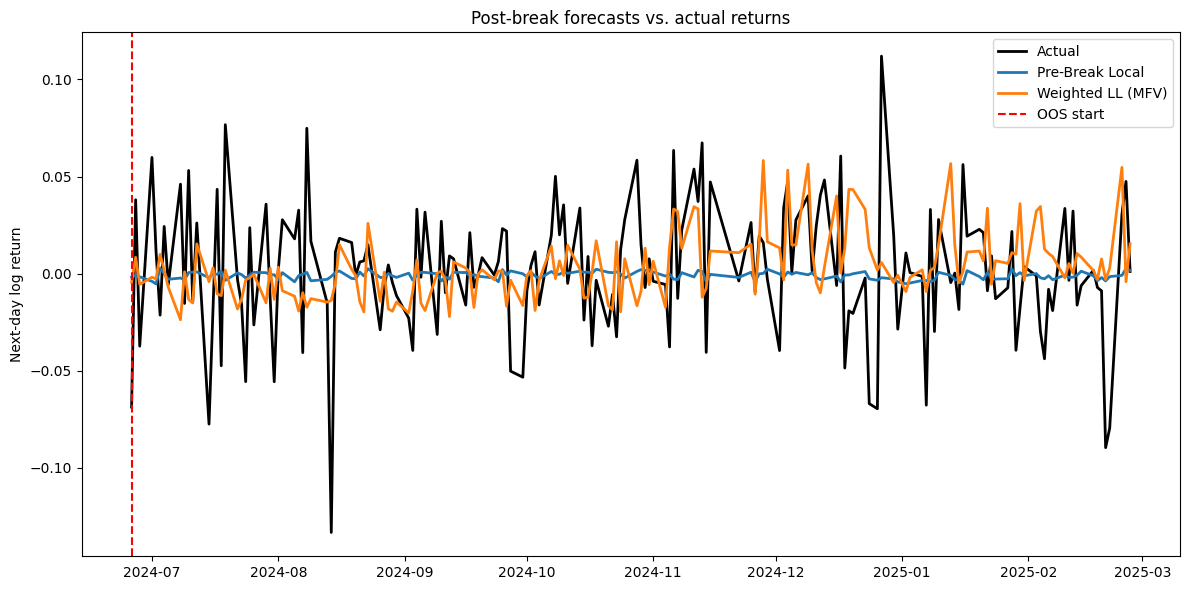

In [9]:
results = []
models_to_show = {
    "Pre-Break Local": pre_pred_oos,
    "Post-Break Local": post_pred_oos,
    "Weighted LL (MFV)": wll_pred_oos,
    **ml_predictions,
}

for name, preds in models_to_show.items():
    msfe = mean_squared_error(oos_target, preds)
    results.append({"Model": name, "Post-break MSFE": msfe})

results_df = pd.DataFrame(results).sort_values("Post-break MSFE")
print("Post-break MSFE (lower is better):")
print(results_df)

# Plot the best two models
best_two = results_df.head(2)["Model"].tolist()
plt.figure(figsize=(12, 6))
plt.plot(oos_df["date"], oos_target, label="Actual", color="black", linewidth=2)
for name in best_two:
    plt.plot(oos_df["date"], models_to_show[name], label=name, linewidth=2)
plt.axvline(oos_df["date"].iloc[0], color="red", linestyle="--", label="OOS start")
plt.title("Post-break forecasts vs. actual returns")
plt.ylabel("Next-day log return")
plt.legend()
plt.tight_layout()
plt.show()



## How to use

1. Open this notebook in Jupyter or VS Code.
2. Click **Run All** – the cells load the data, detect the break, fit all models, and plot results.
3. The `results_df` table reports post-break MSFE so you can compare WLL against the ML baselines.

_No manual parameter tuning is required._
